# Imports

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Part (a)

## Load in Fama French Portfolio Data

In [15]:
# Read the file, skipping header text rows and limiting to monthly data
ff = pd.read_csv("F-F_Research_Data_Factors 3.CSV", skiprows=3, nrows=1182)

# Rename the date column for clarity
ff.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

# Convert Date to string to extract Year and Month
ff['Date'] = ff['Date'].astype(str)
ff['Year'] = ff['Date'].str[:4].astype(int)
ff['Month'] = ff['Date'].str[4:].astype(int)

# Convert other values to floats
ff['Mkt-RF'] = ff['Mkt-RF'].astype(float)
ff['RF'] = ff['RF'].astype(float)

# Pull the columns we want
ff = ff[['Year', 'Month', 'Mkt-RF', 'RF']]

# Show the updated DataFrame
print(ff.head())


   Year  Month  Mkt-RF    RF
0  1926      7    2.96  0.22
1  1926      8    2.64  0.25
2  1926      9    0.36  0.23
3  1926     10   -3.24  0.32
4  1926     11    2.53  0.31


## Calculate Market Portfolio Statistics

In [22]:
# Compute market return
ff["Mkt"] = ff["Mkt-RF"] + ff["RF"]

# Compute average monthly return, volatility, and Sharpe ratio
mp_avg_return = ff["Mkt"].mean()
mp_volatility = ff["Mkt"].std()
mp_avg_excess_return = ff["Mkt-RF"].mean()
mp_sharpe_ratio = mp_avg_excess_return / mp_volatility

print(f"MP Average Monthly Return: {mp_avg_return:.4f}")
print(f"MP Volatility: {mp_volatility:.4f}")
print(f"MP Sharpe Ratio: {mp_sharpe_ratio:.4f}")

MP Average Monthly Return: 0.9557
MP Volatility: 5.3169
MP Sharpe Ratio: 0.1291


# Part (b)

## Load in Strategies Dataset

In [17]:
# Read the file
ss = pd.read_csv("ps1_strategies.csv")

# Convert Date to string to extract Year and Month
ss['date'] = ss['date'].astype(str)
ss['Year'] = ss['date'].str[:4].astype(int)
ss['Month'] = ss['date'].str[4:].astype(int)

# Make other values floats
ss['CA'] = ss['CA'].astype(float)

# Pull the columns we want
ss = ss[['Year', 'Month', 'CA']]

# Show the updated DataFrame
print(ss.head())

   Year  Month        CA
0  1990      1 -1.771984
1  1990      2  1.418966
2  1990      3  1.375007
3  1990      4 -0.395588
4  1990      5  2.588010


## Merge the Datasets on Date

In [31]:
# Merge on Year and Month
merged = pd.merge(ss, ff, on=['Year', 'Month'], how='inner')

# Check merged result
print(merged.head())

   Year  Month        CA  Mkt-RF    RF   Mkt
0  1990      1 -1.771984   -7.85  0.57 -7.28
1  1990      2  1.418966    1.11  0.57  1.68
2  1990      3  1.375007    1.83  0.64  2.47
3  1990      4 -0.395588   -3.36  0.69 -2.67
4  1990      5  2.588010    8.42  0.68  9.10


## Calculate Constant Alpha Statistics

In [33]:
# First, find total returns from strategy
merged['TR'] = merged["CA"] + merged["RF"]

# Then, compute average monthly return, volatility, and Sharpe ratio
ca_avg_return = merged['TR'].mean()
ca_volatility = merged['TR'].std()
ca_avg_excess_return = merged["CA"].mean()
ca_sharpe_ratio = ca_avg_excess_return / ca_volatility

print(f"CA Average Monthly Return: {ca_avg_return:.4f}")
print(f"CA Volatility: {ca_volatility:.4f}")
print(f"CA Sharpe Ratio: {ca_sharpe_ratio:.4f}")

CA Average Monthly Return: 0.9425
CA Volatility: 2.6183
CA Sharpe Ratio: 0.2803


# Part (c)

In [34]:
def estimate_capm(y):
    """
    Estimates CAPM alpha and beta for a given portfolio.

    Parameters:
        y : [pd.Series] The excess returns of the asset or strategy (i.e., 
                        asset return minus risk-free rate).

    Returns:
        dict: Contains alpha, beta, and regression summary.
    """
    # Set up regression: Excess_Portfolio ~ Market Excess Return (Mkt-RF)
    X = merged['Mkt-RF']

    X = sm.add_constant(X)  # Add intercept for alpha
    model = sm.OLS(y, X).fit()

    alpha = model.params['const']
    beta = model.params['Mkt-RF']

    return {
        'alpha': alpha,
        'beta': beta,
        'summary': model.summary(),
    }

# Part (d)

In [35]:
results = estimate_capm(merged['CA'])
print(f"Alpha: {results['alpha']:.4f}")
print(f"Beta: {results['beta']:.4f}")
print(results['summary'])

Alpha: 0.3980
Beta: 0.4887
                            OLS Regression Results                            
Dep. Variable:                     CA   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     866.8
Date:                Fri, 11 Apr 2025   Prob (F-statistic):          1.17e-101
Time:                        22:05:35   Log-Likelihood:                -716.07
No. Observations:                 397   AIC:                             1436.
Df Residuals:                     395   BIC:                             1444.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3980    

# Part (e)

In [36]:
# Calculate CAPM-implied return for each time period
merged['RP_hat'] = merged['RF'] + results['beta'] * merged['Mkt-RF']
print(merged.head())

   Year  Month        CA  Mkt-RF    RF   Mkt        TR    RP_hat
0  1990      1 -1.771984   -7.85  0.57 -7.28 -1.201984 -3.266388
1  1990      2  1.418966    1.11  0.57  1.68  1.988966  1.112470
2  1990      3  1.375007    1.83  0.64  2.47  2.015007  1.534343
3  1990      4 -0.395588   -3.36  0.69 -2.67  0.294412 -0.952072
4  1990      5  2.588010    8.42  0.68  9.10  3.268010  4.794954


# Part (f)

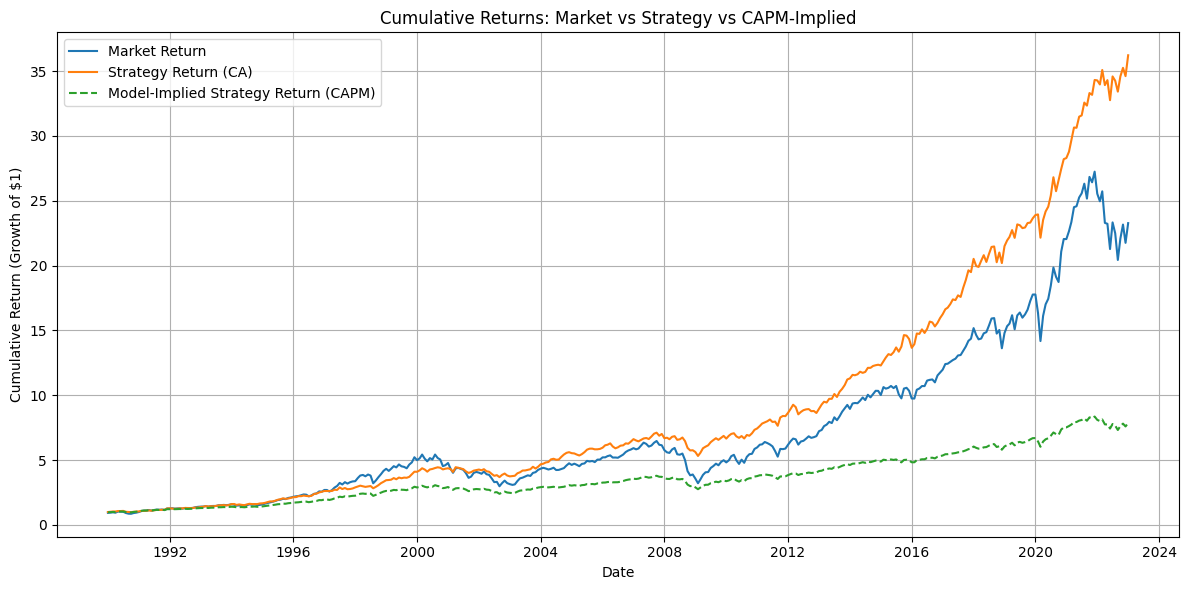

In [37]:
# Compute cumulative returns
# "If I invested $1 at the start and reinvested returns each month, how much 
# money would I have at each time point?"
# Convert from percentage returns to decimal returns
merged['Mkt_cum'] = (1 + merged['Mkt'] / 100).cumprod()
merged['TR_cum'] = (1 + merged['TR'] / 100).cumprod()
merged['RP_hat_cum'] = (1 + merged['RP_hat'] / 100).cumprod()

# Create time axis from Year and Month
merged['Date'] = pd.to_datetime(merged['Year'].astype(str) + 
                                 merged['Month'].astype(str).str.zfill(2), 
                                 format='%Y%m')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['Mkt_cum'], label='Market Return')
plt.plot(merged['Date'], merged['TR_cum'], label='Strategy Return (CA)')
plt.plot(merged['Date'], merged['RP_hat_cum'], 
         label='Model-Implied Strategy Return (CAPM)', linestyle='--')

plt.title('Cumulative Returns: Market vs Strategy vs CAPM-Implied')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Growth of $1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Part (g)

TODO